### LASSO parameter range experiments, summary across all genes

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
base_results_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'results', 'lasso_range_lr_all_features'
)

training_dataset = 'all_other_cancers'
results_dir = os.path.join(base_results_dir, training_dataset)

# cutoff to filter out "dummy regressor" over-regularized models
# these can deflate performance around feature count 0, which can lead to
# spurious positive correlations between model size and performance
# set to None for no cutoff
quantile_cutoff = 0.01

# 'aupr' or 'auroc'
metric = 'aupr'

# 'pearson', 'spearman', or 'ccc'
correlation = 'pearson'

output_plots = True
output_plots_dir = cfg.cancer_type_lasso_range_dir

### Get coefficient information for each lasso penalty

In [3]:
nz_coefs_df = []

# get pancancer coefs info for now
for coef_info in au.generate_nonzero_coefficients_lasso_range(results_dir):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
nz_coefs_df.lasso_param = nz_coefs_df.lasso_param.astype(float)
print(nz_coefs_df.shape)
print(nz_coefs_df.gene.unique())
nz_coefs_df.head()

(35520, 6)
['MAP3K1' 'TP53' 'RB1' 'BRAF' 'ARID2' 'JAK3' 'H3F3A' 'MET' 'CDKN2A'
 'NCOR1' 'FLT3' 'CREBBP' 'SMARCA4' 'FOXL2' 'BCOR' 'NRAS' 'ERBB2' 'ARID1A'
 'PDGFRA' 'MED12' 'SETBP1' 'KDM6A' 'STK11' 'NOTCH1' 'SMAD4' 'ARID1B'
 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'EP300' 'ATRX' 'HRAS' 'GNAS' 'CTNNB1' 'PTEN'
 'DNMT1' 'PIK3CA' 'NOTCH2' 'GATA2' 'CARD11' 'KIT' 'ATM' 'CDH1' 'BAP1'
 'SF3B1' 'RNF43' 'NF1' 'PRDM1' 'NFE2L2' 'BRCA2' 'SETD2' 'CASP8' 'SPOP'
 'PPP2R1A' 'KRAS']


,gene,cancer_type,lasso_param,seed,fold,nz_coefs
0,MAP3K1,BRCA,1.0,1,0,113
1,MAP3K1,BRCA,1.0,1,1,113
2,MAP3K1,BRCA,1.0,1,2,132
3,MAP3K1,BRCA,1.0,1,3,128
4,MAP3K1,UCEC,2000.0,42,0,8788


### Get performance information for each lasso penalty

In [4]:
perf_df = au.load_prediction_results_lasso_range(results_dir, training_dataset)
perf_df.lasso_param = perf_df.lasso_param.astype(float)

print(perf_df.shape)
print(perf_df.gene.unique())
perf_df.head()

(106560, 10)
['MAP3K1' 'TP53' 'RB1' 'BRAF' 'ARID2' 'JAK3' 'H3F3A' 'MET' 'CDKN2A'
 'NCOR1' 'FLT3' 'CREBBP' 'SMARCA4' 'FOXL2' 'BCOR' 'NRAS' 'ERBB2' 'ARID1A'
 'PDGFRA' 'MED12' 'SETBP1' 'KDM6A' 'STK11' 'NOTCH1' 'SMAD4' 'ARID1B'
 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'EP300' 'ATRX' 'HRAS' 'GNAS' 'CTNNB1' 'PTEN'
 'DNMT1' 'PIK3CA' 'NOTCH2' 'GATA2' 'CARD11' 'KIT' 'ATM' 'CDH1' 'BAP1'
 'SF3B1' 'RNF43' 'NF1' 'PRDM1' 'NFE2L2' 'BRCA2' 'SETD2' 'CASP8' 'SPOP'
 'PPP2R1A' 'KRAS']


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param
0,1.00000,1.000000,MAP3K1,BRCA,signal,1,train,0,all_other_cancers,1.0
1,0.43147,0.062268,MAP3K1,BRCA,signal,1,test,0,all_other_cancers,1.0
2,0.49347,0.062197,MAP3K1,BRCA,signal,1,cv,0,all_other_cancers,1.0
3,1.00000,1.000000,MAP3K1,BRCA,signal,1,train,1,all_other_cancers,1.0
4,0.36746,0.084355,MAP3K1,BRCA,signal,1,test,1,all_other_cancers,1.0


### Compare feature selection with performance

In [5]:
coefs_perf_df = (nz_coefs_df
    .rename(columns={'cancer_type': 'holdout_cancer_type'})
    .merge(perf_df[perf_df.signal == 'signal'],
           on=['gene', 'holdout_cancer_type', 'seed', 'fold', 'lasso_param'])
    .drop(columns=['signal', 'experiment'])
)

print(coefs_perf_df.shape)
coefs_perf_df.head()

(106560, 9)


,gene,holdout_cancer_type,lasso_param,seed,fold,nz_coefs,auroc,aupr,data_type
0,MAP3K1,BRCA,1.0,1,0,113,1.00000,1.000000,train
1,MAP3K1,BRCA,1.0,1,0,113,0.43147,0.062268,test
2,MAP3K1,BRCA,1.0,1,0,113,0.49347,0.062197,cv
3,MAP3K1,BRCA,1.0,1,1,113,1.00000,1.000000,train
4,MAP3K1,BRCA,1.0,1,1,113,0.36746,0.084355,test


cutoff: 0.0


,gene,holdout_cancer_type,lasso_param,seed,fold,nz_coefs,auroc,aupr,data_type
53279,FBXW7,BLCA,0.001,42,3,0,0.5,0.110950,cv
12571,BRAF,THCA,0.001,1,2,0,0.5,0.616670,test
12572,BRAF,THCA,0.001,1,2,0,0.5,0.170090,cv
12573,BRAF,THCA,0.001,1,3,0,0.5,0.186760,train
12574,BRAF,THCA,0.001,1,3,0,0.5,0.533330,test
12575,BRAF,THCA,0.001,1,3,0,0.5,0.211140,cv
59931,EP300,BLCA,0.001,42,1,0,0.5,0.075716,train
59930,EP300,BLCA,0.001,42,0,0,0.5,0.068266,cv


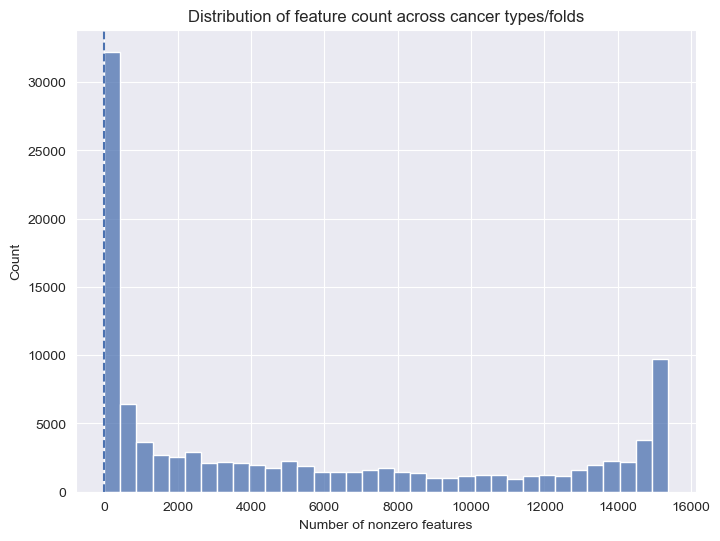

In [6]:
sns.set({'figure.figsize': (8, 6)})

sns.histplot(coefs_perf_df.nz_coefs)
plt.title('Distribution of feature count across cancer types/folds')
plt.xlabel('Number of nonzero features')

# calculate quantile cutoff if included
# models below the cutoff get filtered out in the next cell, here we'll visualize the
# distribution and a few of the filtered rows
if quantile_cutoff is not None:
    nz_coefs_cutoff = coefs_perf_df.nz_coefs.quantile(q=quantile_cutoff)
    plt.gca().axvline(nz_coefs_cutoff, linestyle='--')
    print('cutoff:', nz_coefs_cutoff)
    
coefs_perf_df.loc[coefs_perf_df.nz_coefs.sort_values()[:8].index, :]

### Get "best" LASSO parameters and compare performance across all genes

We want to use two different strategies to pick the "best" LASSO parameter:

1. Choose the top 25% of LASSO parameters based on validation set AUPR, then take the smallest model (least nonzero coefficients) in that set. This is the "parsimonious" approach that assumes that smaller models will generalize better.
2. Choose the top LASSO parameter based solely on validation set AUPR, without considering model size. This is the "non-parsimonious" approach.

We'll do this for each gene/cancer type in the dataset below, and plot the distribution of differences between the two strategies, as a way to quantify which strategy is "better" for generalization across cancer types.

In [7]:
def get_top_and_smallest_diff(gene, cancer_type):
    top_df = (
        perf_df[(perf_df.gene == gene) &
                (perf_df.data_type == 'cv') &
                (perf_df.signal == 'signal') &
                (perf_df.holdout_cancer_type == cancer_type)]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
          .sort_values(by='mean_aupr', ascending=False)
    )
    top_df.index = top_df.index.astype(float)
    top_df['aupr_rank'] = top_df.mean_aupr.rank(ascending=False)
    top_5_lasso = top_df.loc[top_df.aupr_rank <= 5, :].index
    
    # get parameter with best validation performance
    top_lasso_param = top_5_lasso[0]

    # get parameter in top 5 validation performance with least nonzero coefficients
    smallest_lasso_param = (
        nz_coefs_df[(nz_coefs_df.gene == gene) & 
                    (nz_coefs_df.cancer_type == cancer_type) &
                    (nz_coefs_df.lasso_param.isin(top_5_lasso))]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .sort_values(by='nz_coefs', ascending=True)
    ).index[0]
    
    holdout_df = (
        perf_df[(perf_df.gene == gene) &
                (perf_df.data_type == 'test') &
                (perf_df.signal == 'signal') &
                (perf_df.holdout_cancer_type == cancer_type)]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
    )
    
    top_smallest_diff = (
        holdout_df.loc[top_lasso_param, 'mean_aupr'] -
        holdout_df.loc[smallest_lasso_param, 'mean_aupr']
    )
    return [gene, cancer_type, top_lasso_param, smallest_lasso_param, top_smallest_diff]

print(get_top_and_smallest_diff('SETD2', 'KIRP'))

['SETD2', 'KIRP', 10.0, 0.05, 0.22873374999999996]


In [8]:
all_top_smallest_diff_df = []

for gene in perf_df.gene.unique():
    for cancer_type in perf_df[perf_df.gene == gene].holdout_cancer_type.unique():
        all_top_smallest_diff_df.append(get_top_and_smallest_diff(gene, cancer_type))
        
all_top_smallest_diff_df = pd.DataFrame(
    all_top_smallest_diff_df,
    columns=['gene', 'cancer_type', 'top_lasso_param',
             'smallest_lasso_param', 'top_smallest_diff']
)

all_top_smallest_diff_df.head()

,gene,cancer_type,top_lasso_param,smallest_lasso_param,top_smallest_diff
0,MAP3K1,BRCA,10.00,0.01,-0.004655
1,MAP3K1,UCEC,1.00,0.01,-0.019831
2,TP53,PRAD,0.05,0.01,-0.016208
3,TP53,READ,0.05,0.01,-0.001199
4,TP53,KICH,0.05,0.01,0.059441


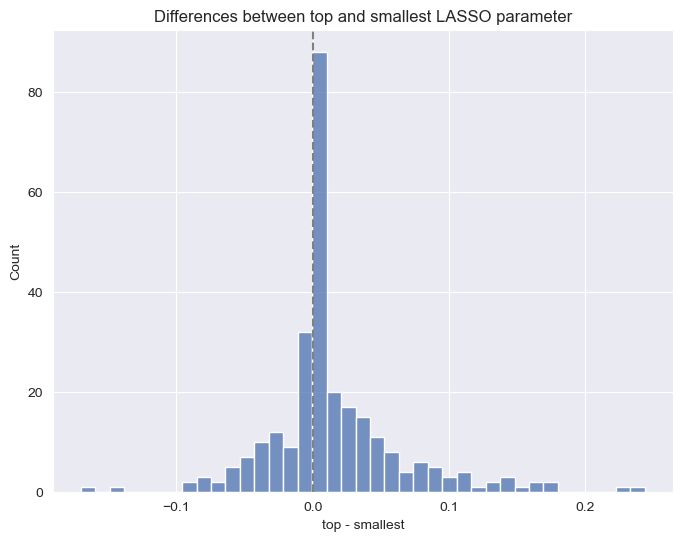

In [9]:
sns.set({'figure.figsize': (8, 6)})

sns.histplot(all_top_smallest_diff_df.top_smallest_diff)
plt.title('Differences between top and smallest LASSO parameter')
plt.xlabel('top - smallest')
plt.gca().axvline(0, color='grey', linestyle='--')

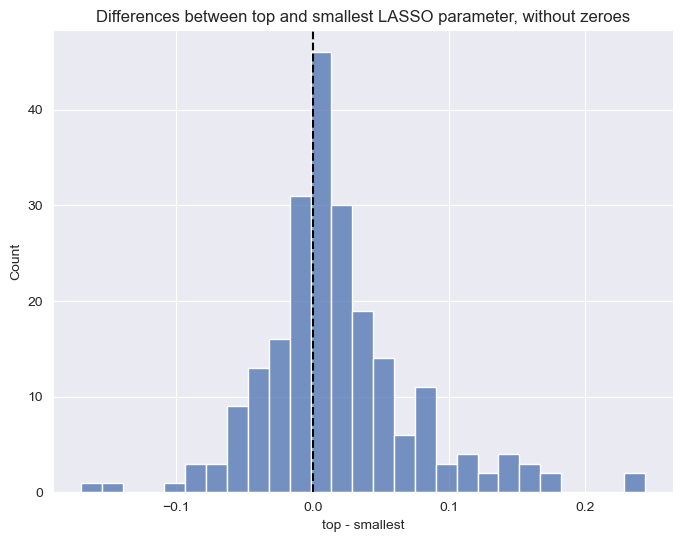

In [10]:
sns.set({'figure.figsize': (8, 6)})

sns.histplot(
    all_top_smallest_diff_df[all_top_smallest_diff_df.top_smallest_diff != 0.0].top_smallest_diff
)
plt.title('Differences between top and smallest LASSO parameter, without zeroes')
plt.xlabel('top - smallest')
plt.gca().axvline(0, color='black', linestyle='--')

In [11]:
all_top_smallest_diff_df.sort_values(by='top_smallest_diff', ascending=False).head(10)

,gene,cancer_type,top_lasso_param,smallest_lasso_param,top_smallest_diff
200,PIK3CA,READ,0.05,0.005,0.243579
258,SETD2,KIRP,10.00,0.050,0.228734
257,SETD2,KIRC,10.00,0.050,0.174029
186,PTEN,STAD,0.05,0.005,0.172630
187,PTEN,LUSC,0.05,0.005,0.165499
158,EP300,CESC,10.00,0.010,0.165495
178,PTEN,LGG,0.05,0.005,0.157514
102,PDGFRA,LUSC,0.01,0.005,0.146060
162,ATRX,SARC,0.05,0.005,0.143666
273,KRAS,BLCA,0.05,0.010,0.140137


In [12]:
all_top_smallest_diff_df.sort_values(by='top_smallest_diff', ascending=True).head(10)

,gene,cancer_type,top_lasso_param,smallest_lasso_param,top_smallest_diff
49,CDKN2A,LGG,0.05,0.010,-0.169929
122,SMAD4,LUAD,0.05,0.005,-0.146155
172,CTNNB1,SKCM,10.00,0.050,-0.094103
121,SMAD4,HNSC,0.05,0.005,-0.086531
249,NFE2L2,UCEC,0.10,0.010,-0.084808
25,RB1,LIHC,0.05,0.005,-0.081980
22,RB1,LUSC,0.05,0.010,-0.075335
19,TP53,LGG,0.05,0.010,-0.065263
175,CTNNB1,LIHC,1.00,0.050,-0.064836
204,PIK3CA,OV,0.05,0.005,-0.061095
